In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [3]:
path = './'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [4]:
# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

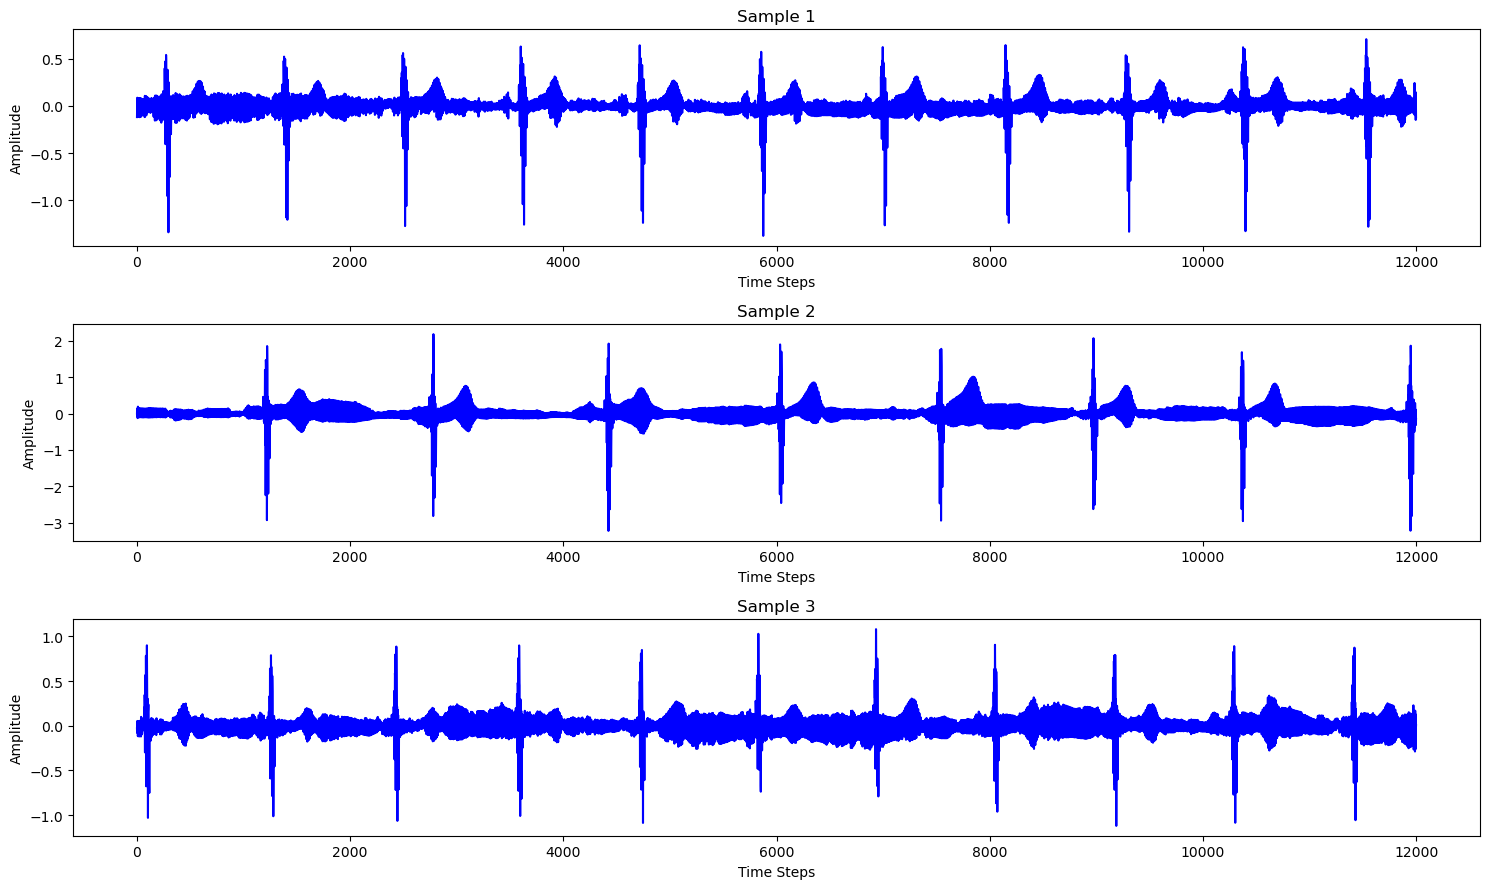

In [26]:
import matplotlib.pyplot as plt

# Plot multiple ECG signals in subplots
def plot_samples_in_subplots(X, num_samples=5):
    plt.figure(figsize=(15, num_samples * 3))  # Adjust figure size as needed
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)  # Create a subplot for each sample
        plt.plot(X[i].flatten(), color='b')
        plt.title(f"Sample {i+1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Amplitude")
        plt.tight_layout()  # Adjust spacing to prevent overlap
    plt.show()

# Call the function to display sample ECG signals in subplots
plot_samples_in_subplots(X, 3)



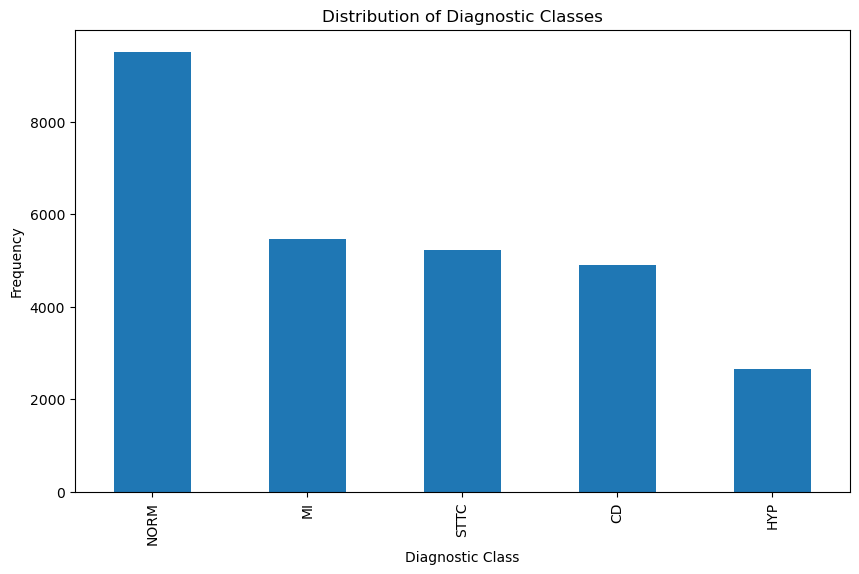

In [27]:
# 2. Class Distribution of diagnostic_superclass
def plot_class_distribution(Y):
    class_counts = Y['diagnostic_superclass'].explode().value_counts()
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar')
    plt.title("Distribution of Diagnostic Classes")
    plt.xlabel("Diagnostic Class")
    plt.ylabel("Frequency")
    plt.show()

plot_class_distribution(Y)

In [5]:
def aggregate_diagnostic(y_dic):
    tmp = []
   #Y
   #  print(y_dic.keys())
    for key in y_dic.keys():
        if key in agg_df.index:
            #print("key", key)
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [6]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [7]:
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass


In [8]:
y_train.shape
X_train.shape

(19601, 1000, 12)

Section: Train data using Torchvision models

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.preprocessing import MultiLabelBinarizer

/home/nalla052/.conda/envs/my-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:

# Create label encoding
unique_classes = list(set([item for sublist in y_train for item in sublist]))
class_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}

# Filter out data with no labels in y_train and y_test
y_train_filtered = [labels for labels in y_train if labels]  # Keeps only non-empty labels
X_train_filtered = X_train[np.array([bool(labels) for labels in y_train])]  # Matches X_train to non-empty labels in y_train

y_test_filtered = [labels for labels in y_test if labels]  # Keeps only non-empty labels
X_test_filtered = X_test[np.array([bool(labels) for labels in y_test])]  # Matches X_test to non-empty labels in y_test

# Re-encode the filtered y_train and y_test
y_train_encoded = [class_to_idx[labels[0]] for labels in y_train_filtered]
y_test_encoded = [class_to_idx[labels[0]] for labels in y_test_filtered]

# Convert to tensors
# Convert filtered X to tensors (if needed)
X_train_tensor = torch.tensor(X_train_filtered, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_filtered, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [11]:
# Load pre-trained ResNet model and modify for single-channel ECG data
resnet = models.resnet18(pretrained=True)

# Modify the first convolution layer to accept single channel input
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


# Modify the fully connected layer to match the number of diagnostic classes
num_classes = len(y_train_tensor.unique())  # or use a fixed number if known
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
# Move model to device
resnet.to(device)


/home/nalla052/.conda/envs/my-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nalla052/.conda/envs/my-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
num_classes = len(set(y_train_tensor.tolist()))
print(f"Number of classes: {num_classes}")
print(f"Output layer size: {resnet.fc.out_features}")
print("Unique encoded labels in y_train:", set(y_train_encoded))
print("Unique encoded labels in y_test:", set(y_test_encoded))
print("Length of X_train_filtered:", len(X_train_filtered))
print("Length of y_train_encoded:", len(y_train_encoded))


Number of classes: 5
Output layer size: 5
Unique encoded labels in y_train: {0, 1, 2, 3, 4}
Unique encoded labels in y_test: {0, 1, 2, 3, 4}
Length of X_train_filtered: 19230
Length of y_train_encoded: 19230


In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
# Training loop
num_epochs = 40
training_losses=[]
accuracies=[]
for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss=running_loss/len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    training_losses.append(train_loss)
    accuracies.append(100 * correct / total)
    


Epoch [1/40], Loss: 0.9350, Accuracy: 65.73%
Epoch [2/40], Loss: 0.8008, Accuracy: 70.79%
Epoch [3/40], Loss: 0.7529, Accuracy: 72.40%
Epoch [4/40], Loss: 0.7193, Accuracy: 73.31%
Epoch [5/40], Loss: 0.6945, Accuracy: 73.89%
Epoch [6/40], Loss: 0.6657, Accuracy: 75.24%
Epoch [7/40], Loss: 0.6503, Accuracy: 75.39%
Epoch [8/40], Loss: 0.6337, Accuracy: 76.59%
Epoch [9/40], Loss: 0.6180, Accuracy: 76.98%
Epoch [10/40], Loss: 0.5983, Accuracy: 77.55%
Epoch [11/40], Loss: 0.5797, Accuracy: 78.28%
Epoch [12/40], Loss: 0.5592, Accuracy: 78.92%
Epoch [13/40], Loss: 0.5433, Accuracy: 79.81%
Epoch [14/40], Loss: 0.5141, Accuracy: 80.68%
Epoch [15/40], Loss: 0.4824, Accuracy: 81.59%
Epoch [16/40], Loss: 0.4324, Accuracy: 83.76%
Epoch [17/40], Loss: 0.3972, Accuracy: 85.15%
Epoch [18/40], Loss: 0.3573, Accuracy: 86.42%
Epoch [19/40], Loss: 0.3053, Accuracy: 88.43%
Epoch [20/40], Loss: 0.2558, Accuracy: 90.37%
Epoch [21/40], Loss: 0.2174, Accuracy: 91.90%
Epoch [22/40], Loss: 0.1794, Accuracy: 93.3

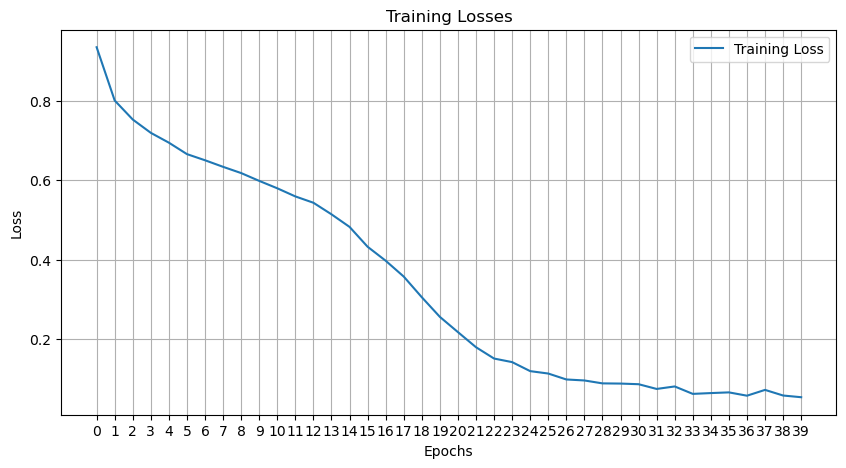

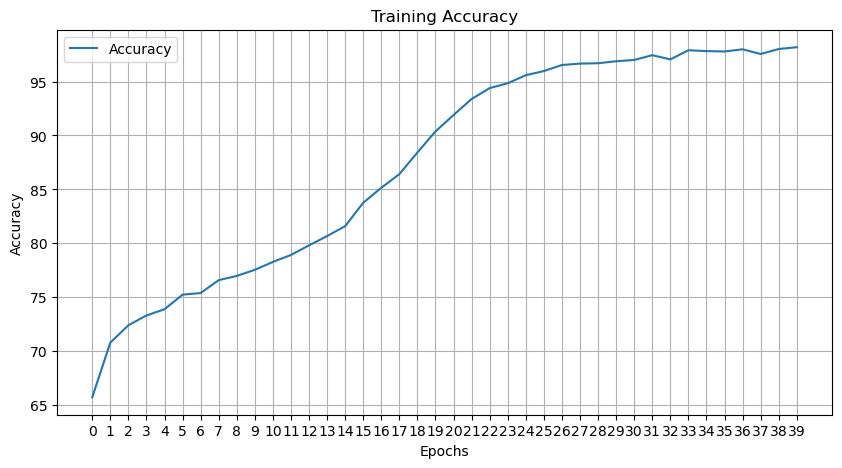

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(len(training_losses))) 
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(len(accuracies))) 
plt.grid()
plt.legend()
plt.show()




In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Evaluation on test set
resnet.eval()
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())  # Append true labels
        y_pred.extend(predicted.cpu().numpy())  # Append predicted labels

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Convert to numpy arrays for sklearn metrics
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class
f1 = f1_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class

# Print classification report (includes precision, recall, F1 for each class)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Test Accuracy (for reference)
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Precision: 0.6793
Recall: 0.6895
F1 Score: 0.6800

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       468
           1       0.77      0.85      0.81       916
           2       0.57      0.42      0.48       317
           3       0.58      0.53      0.56       242
           4       0.61      0.45      0.52       215

    accuracy                           0.69      2158
   macro avg       0.64      0.60      0.61      2158
weighted avg       0.68      0.69      0.68      2158

Test Accuracy: 68.95%


Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [19]:
# Flatten and standardize data (assuming X_train and X_test are in shape [samples, time_steps])
X_train_flat = X_train_filtered.reshape(X_train_filtered.shape[0], -1)
X_test_flat = X_test_filtered.reshape(X_test_filtered.shape[0], -1)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Optionally apply PCA to reduce dimensionality (e.g., reduce to 50 components)
pca = PCA(n_components=50)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)


In [20]:
# Initialize and train logistic regression
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
log_reg.fit(X_train_reduced, y_train_encoded)

# Predict and evaluate on test data
y_pred = log_reg.predict(X_test_reduced)

# Print precision, recall, and F1-score for each class with zero_division parameter
precision = precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0)  # Set zero_division to 0 for ill-defined precision
recall = recall_score(y_test_encoded, y_pred, average='weighted', zero_division=0)  # Set zero_division to 0 for ill-defined recall
f1 = f1_score(y_test_encoded, y_pred, average='weighted', zero_division=0)  # Set zero_division to 0 for ill-defined F1-score

# Displaying metrics for each class
print(f"Overall Precision: {precision:.2f}")
print(f"Overall Recall: {recall:.2f}")
print(f"Overall F1 Score: {f1:.2f}")

# Print accuracy and classification report
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred,zero_division=0))

Overall Precision: 0.34
Overall Recall: 0.43
Overall F1 Score: 0.26
Test Accuracy: 42.63%

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.01      0.02       468
           1       0.43      1.00      0.60       916
           2       0.00      0.00      0.00       317
           3       0.50      0.00      0.01       242
           4       0.00      0.00      0.00       215

    accuracy                           0.43      2158
   macro avg       0.28      0.20      0.13      2158
weighted avg       0.34      0.43      0.26      2158

